# Semantic segmentation with SegFormer and Hugging Face Transformers

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2023/01/25<br>
**Last modified:** 2023/01/29<br>
**Description:** Fine-tuning a SegFormer model variant for semantic segmentation.

## Introduction

In this example, we show how to fine-tune a SegFormer model variant to do
semantic segmentation on a custom dataset. Semantic segmentation is the task of
assigning a category to each and every pixel of an image. SegFormer was proposed in
[SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers](https://arxiv.org/abs/2105.15203).
SegFormer uses a hierarchical Transformer architecture (called "Mix Transformer") as
its encoder and a lightweight decoder for segmentation. As a result, it yields
state-of-the-art performance on semantic segmentation while being more efficient than
existing models. For more details, check out the original paper.

![segformer-arch](https://i.imgur.com/BsrVwYe.png)

We leverage
[Hugging Face Transformers](https://github.com/huggingface/transformers)
to load a pretrained SegFormer checkpoint and fine-tune it on a custom dataset.

**Note:** this example reuses code from the following sources:

* [Official tutorial on segmentation from the TensorFlow team](https://www.tensorflow.org/tutorials/images/segmentation)
* [Hugging Face Task guide on segmentation](https://huggingface.co/docs/transformers/main/en/tasks/semantic_segmentation)

To run this example, we need to install the `transformers` library:

In [1]:
!!pip install transformers -q

[]

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ihYIM7BFL7rugXS2qI8E")
project = rf.workspace("balasai").project("jhv-wp8qu")
dataset = project.version(6).download("coco-segmentation")


loading Roboflow workspace...
loading Roboflow project...


## Load the data

We use the [Oxford-IIIT Pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset for
this example. We leverage `tensorflow_datasets` to load the dataset.

In [3]:
'''import tensorflow_datasets as tfds

dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)'''

'import tensorflow_datasets as tfds\n\ndataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)'

In [4]:
!pip install pycocotools -q

In [5]:
import tensorflow as tf
import numpy as np
from pycocotools.coco import COCO
from typing import List, Dict, Any, Tuple

# Load COCO annotations (replace 'your_annotations_file.json' with your actual file path)
coco_train: COCO = COCO('jhv-6/train/_annotations.coco.json')
coco_valid: COCO = COCO('jhv-6/valid/_annotations.coco.json')    

# Function to generate mask using coco.annToMask
def generate_mask(annotations: List[Dict[str, Any]], image_shape: Tuple[int, int],coco) -> np.ndarray:
    combined_mask: np.ndarray = np.zeros(image_shape[:2], dtype=np.uint8)
    for ann in annotations:
        mask = coco.annToMask(ann)
        combined_mask += mask
    return combined_mask

# Generator function to yield data
def data_generator(coco: COCO, image_dir: str):
    for image_id in coco.imgs:
        image_info: Dict[str, Any] = coco.loadImgs(image_id)[0]
        file_name: str = image_info['file_name']
        image_path: str = f"{image_dir}/{file_name}"

        # Load the actual image using TensorFlow
        image: tf.Tensor = tf.io.read_file(image_path)
        image: tf.Tensor = tf.image.decode_image(image, channels=3)

        # Load the segmentation mask (modify as per your annotation format)
        annotations_ids: List[int] = coco.getAnnIds(imgIds=image_id)
        annotations: List[Dict[str, Any]] = coco.loadAnns(annotations_ids)

        # Extracting labels from annotations (example assumes 'category_id' is used for labels)
        labels: List[int] = [ann['category_id'] for ann in annotations]

        # Generate mask using coco.annToMask
        mask: np.ndarray = generate_mask(annotations, image.numpy().shape,coco)
        mask = tf.expand_dims(mask,axis=-1)
        yield {
            'file_name': file_name,
            'image': image.numpy(),  # Convert to numpy array
            'label': labels,
            'segmentation_mask': mask
        }

# Provide the directory where images are stored
train_directory: str = 'jhv-6/train/'
valid_directory: str = 'jhv-6/valid/'    

# Create the TensorFlow dataset using from_generator
train_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(coco_train, train_directory),
    output_signature={
        'file_name': tf.TensorSpec(shape=(), dtype=tf.string),
        'image': tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        'label': tf.TensorSpec(shape=(None,), dtype=tf.int32),
        'segmentation_mask': tf.TensorSpec(shape=(None, None,1), dtype=tf.uint8),
    }
)
valid_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(coco_valid, valid_directory),
    output_signature={
        'file_name': tf.TensorSpec(shape=(), dtype=tf.string),
        'image': tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        'label': tf.TensorSpec(shape=(None,), dtype=tf.int32),
        'segmentation_mask': tf.TensorSpec(shape=(None, None,1), dtype=tf.uint8),
    }
)
# Print a sample from the dataset
for sample in train_dataset.take(1):
    print(sample)

2024-05-04 21:17:06.132823: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 21:17:06.190563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 21:17:06.856052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
{'file_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Valdes_SRW_WV2_PS_20120919_B17_PNG.rf.de81e9c1e86f53f35447e606e0310529.jpg'>, 'image': <tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [255, 255, 253],
        [251, 251, 249],
        ...,
        [252, 254, 249],
        [252, 254, 249],
        [252, 254, 249]],

       [[ 19,  19,  17],
        [231, 231, 229],
        [255, 255, 253],
        ...,
        [254, 255, 251],
        [254, 255, 251],
        [254, 255, 251]],

       [[  0,   0,   0],
        [  9,   9,   7],
        [  0,   0,   0],
        ...,
        [  0,   1,   0],
        [  0,   1,   0],
        [  0,   1,   0]],

       ...,

       [[  0,   2,   0],
        [  6,  11,   5],
        [  0,   2,   0],
        ...,
        [  0,   0,   0],
        [  0,  

2024-05-04 21:17:07.488173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Prepare the datasets

For preparing the datasets for training and evaluation, we:

* Normalize the images with the mean and standard deviation used during pre-training
SegFormer.
* Subtract 1 from the segmentation masks so that the pixel values start from 0.
* Resize the images.
* Transpose the images such that they are in `"channels_first"` format. This is to make
them compatible with the SegFormer model from Hugging Face Transformers.

In [6]:
import tensorflow as tf
from tensorflow.keras import backend

image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.512, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    #input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    print(datapoint)
    print(datapoint['image'],datapoint['segmentation_mask'])
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )

    input_image, input_mask = normalize(input_image, input_mask)
    #input_image = tf.transpose(input_image, (2, 0, 1))
    return ({"pixel_values": input_image,},tf.squeeze(input_mask))


We now use the above utilities to prepare `tf.data.Dataset` objects including
`prefetch()` for performance. Change the `batch_size` to match the size of the GPU memory
on the GPU that you're using for training.

In [7]:
auto = tf.data.AUTOTUNE
batch_size = 4

train_ds = (
    train_dataset
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)
test_ds = (
    valid_dataset
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

{'file_name': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'image': <tf.Tensor 'args_1:0' shape=(None, None, 3) dtype=uint8>, 'label': <tf.Tensor 'args_2:0' shape=(None,) dtype=int32>, 'segmentation_mask': <tf.Tensor 'args_3:0' shape=(None, None, 1) dtype=uint8>}
Tensor("args_1:0", shape=(None, None, 3), dtype=uint8) Tensor("args_3:0", shape=(None, None, 1), dtype=uint8)
{'file_name': <tf.Tensor 'args_0:0' shape=() dtype=string>, 'image': <tf.Tensor 'args_1:0' shape=(None, None, 3) dtype=uint8>, 'label': <tf.Tensor 'args_2:0' shape=(None,) dtype=int32>, 'segmentation_mask': <tf.Tensor 'args_3:0' shape=(None, None, 1) dtype=uint8>}
Tensor("args_1:0", shape=(None, None, 3), dtype=uint8) Tensor("args_3:0", shape=(None, None, 1), dtype=uint8)


We can check the shapes of the input images and their segmentation maps:

In [8]:
print(train_ds.element_spec)

({'pixel_values': TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None)}, TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None))


## Visualize dataset

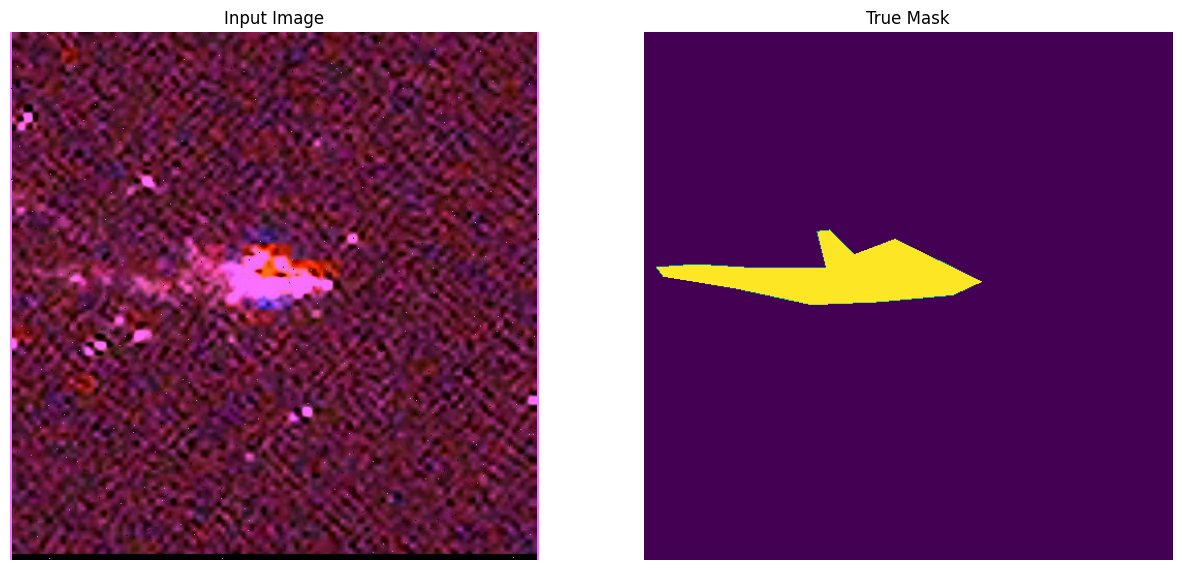

2024-05-04 21:17:08.141199: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


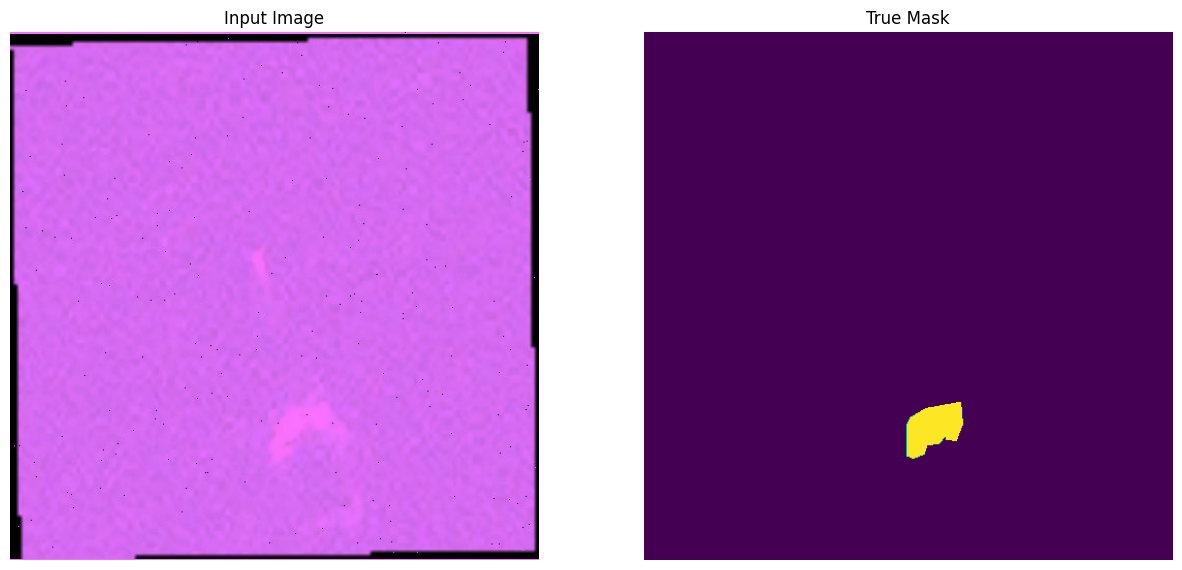

2024-05-04 21:17:08.388326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples,labels in train_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], labels[0]
    #sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])

## Load a pretrained SegFormer checkpoint

We now load a pretrained SegFormer model variant from Hugging Face Transformers. The
SegFormer model comes in different variants dubbed as **MiT-B0** to **MiT-B5**. You can
find these checkpoints
[here](https://huggingface.co/models?pipeline_tag=image-segmentation&sort=downloads&search=segformer).
We load the smallest variant Mix-B0, which produces a good trade-off
between inference efficiency and predictive performance.

In [10]:
import tensorflow as tf
from models import SegFormer_B3
model = SegFormer_B3(input_shape = (512, 512, 3), num_classes = 1)
print(model.summary())

You are using a softmax over axis -1 of a tensor of shape (None, 512, 512, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pixel_values        │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mix_vision_transfo… │ [(None, 128, 128, │ 44,072,128 │ pixel_values[0][… │
│ (MixVisionTransfor… │ 64), (None, 64,   │            │                   │
│                     │ 64, 128), (None,  │            │                   │
│                     │ 32, 32, 320),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 128,  │        128 │ mix_vision_trans… │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │        256 │ mix_vision_trans… │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 32,    │        640 │ mix_vision_trans… │
│ (LayerNormalizatio… │ 320)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 16,    │      1,024 │ mix_vision_trans… │
│ (LayerNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seg_former_head     │ (None, 128, 128,  │  3,152,641 │ layer_normalizat… │
│ (SegFormerHead)     │ 1)                │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_layer        │ (None, 512, 512,  │          0 │ seg_former_head[… │
│ (ResizeLayer)       │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 512, 512,  │          0 │ resize_layer[0][… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,226,817 (180.16 MB)

 Trainable params: 47,225,281 (180.15 MB)

 Non-trainable params: 1,536 (6.00 KB)

None


I0000 00:00:1714837644.814614   12933 service.cc:145] XLA service 0x775b2400c1e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714837644.814644   12933 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1714837644.856852   12933 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]]], dtype=float32)

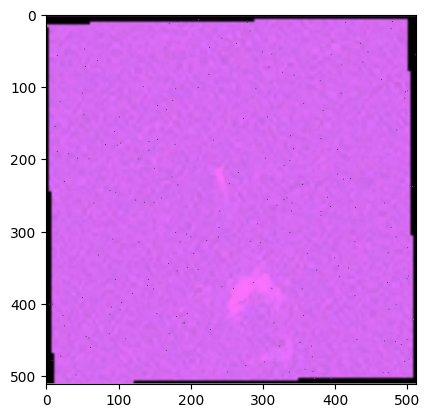

In [11]:
sample_image.shape
from matplotlib import pyplot as plt
plt.imshow(tf.keras.utils.array_to_img(sample_image))
model.predict(tf.expand_dims(sample_image,axis=0))

## Compile the model

In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K

def generalized_lovasz(y_true, y_pred, gamma=2.0, smooth=1e-10):
  # Extract ground truth mask from y_true (assuming y_true is [image, mask])
  y_true = tf.cast(y_true, dtype=K.floatx())
  y_pred = tf.cast(y_pred, dtype=K.floatx())
  # flatten label and prediction tensors
  y_true = tf.reshape(y_true, [-1])
  y_pred = tf.reshape(y_pred, [-1])
  epsilon = K.epsilon()
  # clip values to avoid division by zero
  y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

  logits = K.log(y_pred / (1 - y_pred))
  Splus = tf.reduce_sum(y_true * (1 - logits))
  Sminus = tf.reduce_sum((1 - y_true) * logits)
  loss = K.mean(Splus) - K.mean(K.log(1 + K.exp(-gamma * Sminus)))
  return loss


In [13]:
lr = 0.00006
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr,weight_decay=0.0006)
model.compile(optimizer=optimizer,loss=generalized_lovasz)

Notice that we are not using any loss function for compiling the model. This is because
the forward pass of the model
[implements](https://github.com/huggingface/transformers/blob/820c46a707ddd033975bc3b0549eea200e64c7da/src/transformers/models/segformer/modeling_tf_segformer.py#L873)
the loss computation part when we provide labels alongside the input images. After
computing the loss, the model returned a structured `dataclass` object which is
then used to guide the training process.

With the compiled model, we can proceed and call `fit()` on it to begin the fine-tuning
process!

## Prediction callback to monitor training progress

It helps us to visualize some sample predictions when the model is being fine-tuned,
thereby helping us to monitor the progress of the model. This callback is inspired from
[this tutorial](https://www.tensorflow.org/tutorials/images/segmentation).

In [14]:
from IPython.display import clear_output


def create_mask(pred_mask):
   return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        dataset=dataset.shuffle(20)
        for sample,labels in dataset.take(num):
            images, masks = sample["pixel_values"], labels
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images)
            print(pred_masks.shape)
            #images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))


## Train model

In [15]:
pip install keras-tuner --upgrade

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Increase the number of epochs if the results are not of expected quality.
epochs = 50

history = model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[DisplayCallback(test_ds),tf.keras.callbacks.ReduceLROnPlateau(min_lr=0.0)],
    epochs=epochs,
)

Epoch 1/50


## Inference

We perform inference on a few samples from the test set.

In [ ]:
show_predictions(test_ds, 5)

## Conclusion

In this example, we learned how to fine-tune a SegFormer model variant on a custom
dataset for semantic segmentation. In the interest of brevity, the example
was kept short. However, there are a couple of things, you can further try out:

* Incorporate data augmentation to potentially improve the results.
* Use a larger SegFormer model checkpoint to see how the results are affected.
* Push the fine-tuned model to the Hugging Face for sharing with the community easily.
You can do so just by doing `model.push_to_hub("your-username/your-awesome-model")`.
And then you can load the model by doing
`TFSegformerForSemanticSegmentation.from_pretrained("your-username/your-awesome-model"`).
[Here](https://github.com/huggingface/notebooks/blob/main/examples/semantic_segmentation-tf.ipynb)
is an end-to-end example if you're looking for a reference.
* If you'd rather push the model checkpoints to the Hub as the model is being
fine-tuned you can instead use the `PushToHubCallback` Keras callback.
[Here](https://gist.github.com/sayakpaul/f474ffb01f0cdcc8ba239357965c3bca) is an example.
[Here](https://huggingface.co/sayakpaul/mit-b0-finetuned-pets) is an example of a model
repository that was created using this callback.